# The Enron Corpus
## A practice in EDA and Machine Learning
##### Tania Lincoln January 15, 2018

### Background
Enron was one of the largest corporations in the United States.  By December 2002, it was bankrupt due to widespread corporate fraud and misleading accouting practices.  A Federal investigation resulted where many leaders were found guilty.

The Enron dataset contains approximately 600,000 emails generated by 158 employees of the Enron Corporation.  It was obtained by the Federal Energy Regulatory Commission during Enron's collapse.  At the conclusion of the investigation, the emails and information collected were deemed to be public domain to be used for research or academic purposes.

The corpus is unique in that its one of the only public mass collections of real emails available for study.

### Summary
In this project, we will study the corpus to build a person of interest identifier using emails and financial data.  A person of interest is someone who was indicted for fraud, settled, or testified in exchange for immunity.

This document will step through the EDA techniques to understand and clean the data; and explain machine learning algorithms applied to identify a person of interest.  Machine learning uses pattern recognition and statistics in a programatically to predict outcomes.

### Import Libraries

In [1]:
#import basic libraries
import sys
import pickle
import numpy as np
import pandas as pd
import csv
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pprint

# add this path statement in order to add custom libraries
sys.path.append("../../ud120-projects-master/tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

sys.path.append("../utilities/")
from tool import scatter_plot

C:\Users\lincolnt\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Display Current Environment Info

In [2]:
# Always good practice to note the version info
print("python " + sys.version)
print("")
print("pandas " + str(pd.__version__))
print("numpy " + np.__version__)
print("matplotlib " + mpl.__version__)
print("seaborn " + sns.__version__)
print("stats " + statsmodels.__version__)

python 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 19 2016, 13:29:36) [MSC v.1500 64 bit (AMD64)]

pandas 0.19.2
numpy 1.13.1
matplotlib 2.0.0
seaborn 0.7.1
stats 0.6.1


### List of Features
These features have been predefined in the project.  

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

POI label: [‘poi’] (boolean, represented as integer)

### Load Data

In [3]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Explore Data

#### How many people are in the dataset?

In [4]:
### How many people are in the dataset
print "There are ", len(data_dict.keys()), \
    " executives within the Enron corpus."

There are  146  executives within the Enron corpus.


#### Who is in the dataset?

In [5]:
### Look at the keys
print "These are the keys in the dataset \n"
pprint.pprint(data_dict.keys())

These are the keys in the dataset 

['METTS MARK',
 'BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'CORDES WILLIAM R',
 'HANNON KEVIN P',
 'MORDAUNT KRISTINA M',
 'MEYER ROCKFORD G',
 'MCMAHON JEFFREY',
 'HORTON STANLEY C',
 'PIPER GREGORY F',
 'HUMPHREY GENE E',
 'UMANOFF ADAM S',
 'BLACHMAN JEREMY M',
 'SUNDE MARTIN',
 'GIBBS DANA R',
 'LOWRY CHARLES P',
 'COLWELL WESLEY',
 'MULLER MARK S',
 'JACKSON CHARLENE R',
 'WESTFAHL RICHARD K',
 'WALTERS GARETH W',
 'WALLS JR ROBERT H',
 'KITCHEN LOUISE',
 'CHAN RONNIE',
 'BELFER ROBERT',
 'SHANKMAN JEFFREY A',
 'WODRASKA JOHN',
 'BERGSIEKER RICHARD P',
 'URQUHART JOHN A',
 'BIBI PHILIPPE A',
 'RIEKER PAULA H',
 'WHALEY DAVID A',
 'BECK SALLY W',
 'HAUG DAVID L',
 'ECHOLS JOHN B',
 'MENDELSOHN JOHN',
 'HICKERSON GARY J',
 'CLINE KENNETH W',
 'LEWIS RICHARD',
 'HAYES ROBERT E',
 'MCCARTY DANNY J',
 'KOPPER MICHAEL J',
 'LEFF DANIEL P',
 'LAVORATO JOHN J',
 'BERBERIAN DAVID',
 'DETMERING TIMOTHY J',
 'WAKEHAM JOHN',
 'POWERS WILLIAM',
 'GOLD JOSEPH',
 'B

In [6]:
pprint.pprint(data_dict)

{'ALLEN PHILLIP K': {'bonus': 4175000,
                     'deferral_payments': 2869717,
                     'deferred_income': -3081055,
                     'director_fees': 'NaN',
                     'email_address': 'phillip.allen@enron.com',
                     'exercised_stock_options': 1729541,
                     'expenses': 13868,
                     'from_messages': 2195,
                     'from_poi_to_this_person': 47,
                     'from_this_person_to_poi': 65,
                     'loan_advances': 'NaN',
                     'long_term_incentive': 304805,
                     'other': 152,
                     'poi': False,
                     'restricted_stock': 126027,
                     'restricted_stock_deferred': -126027,
                     'salary': 201955,
                     'shared_receipt_with_poi': 1407,
                     'to_messages': 2902,
                     'total_payments': 4484442,
                     'total_stock_value': 17295

#### How many people are POIs?

In [6]:
### Find out how many POIs are in the dataset
poi_count = 0
for person in data_dict.iterkeys():
    if data_dict[person]["poi"]:
        poi_count += 1
print "There are", poi_count, "people of interests"

There are 18 people of interests


#### How many features are assigned to each person?

In [7]:
### Find out how many features have been assigned to each person
feature_length = 0
for person in data_dict.iterkeys():
    if len(data_dict[person]) > feature_length:
        feature_length = len(data_dict[person])
print "There are", feature_length, "features assigned to each person."

There are 21 features assigned to each person.


#### Load the default features for now and take a look at one row.

In [8]:
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features = ['poi',\
            'salary',                    'deferral_payments',   'total_payments',             \
            'loan_advances',             'bonus',               'restricted_stock_deferred',  \
            'deferred_income',           'total_stock_value',   'expenses',                   \
            'exercised_stock_options',   'other',               'long_term_incentive',        \
            'restricted_stock',          'director_fees'] 

all_data = featureFormat(data_dict, features)

### look at the first element in data too see what it looks like
pprint.pprint(all_data[0])

array([       0.,   365788.,        0.,  1061827.,        0.,   600000.,
              0.,        0.,   585062.,    94299.,        0.,     1740.,
              0.,   585062.,        0.])


### Features

#### What does salary and bonus look like?

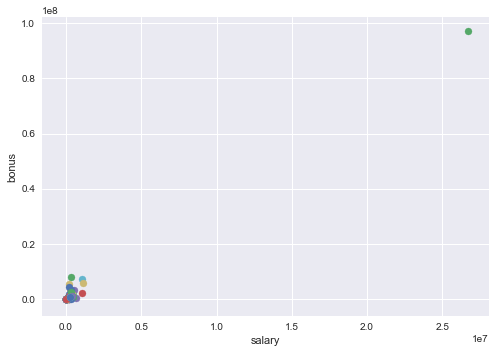

In [9]:
### look at salary and bonus, plotted
for point in all_data:
    salary = point[1]
    bonus = point[5]
    mpl.pyplot.scatter( salary, bonus )

mpl.pyplot.xlabel("salary")
mpl.pyplot.ylabel("bonus")
mpl.pyplot.show()


We see there is a plotted point with over \$8,000,000 of bonuses and \$1,000,000 of salary.  
This outlier is so far away from the majaority of the points.  We will need to investigate this more.

#### Outlier investigation

In [10]:
### There is a huge outlier, further investigate who it belongs to
for element in data_dict:
    if ((data_dict[element]['salary'] > 1000000 and data_dict[element]['bonus'] > 8000000)\
        and (data_dict[element]['salary'] != 'NaN' and data_dict[element]['bonus'] != 'NaN')):
        pprint.pprint(element)


'TOTAL'


A total row is in the dataset.  This will be removed so we know we're working with a dataset of real people.

#### Remove Outlier

In [11]:
### Remove outliers
data_dict.pop('TOTAL')

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

#### Check to see if there are other entries that are obviously not a person

In [12]:
### Most names appear to follow this format:
### last name, first name, middle intitial
### because we found a name of "TOTAL",
### let's see if there is anything else to remove.
for each in data_dict:
    if len(each.split()) > 3 or len(each.split()) < 1:
        print each

WALLS JR ROBERT H
BOWEN JR RAYMOND M
OVERDYKE JR JERE C
PEREIRA PAULO V. FERRAZ
BLAKE JR. NORMAN P
THE TRAVEL AGENCY IN THE PARK
WHITE JR THOMAS E
WINOKUR JR. HERBERT S
DERRICK JR. JAMES V
DONAHUE JR JEFFREY M
GLISAN JR BEN F


The Travel Agency In The Park seems wrong.  Examine it.

#### Look at the Travel Agency Row

In [13]:
pprint.pprint(data_dict['THE TRAVEL AGENCY IN THE PARK'])

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}


Because this is not a person of interest and most columns are null, we will remove this row as part of the data cleansing.

#### Remove the park entry

In [15]:
### Remove outliers
data_dict.pop('THE TRAVEL AGENCY IN THE PARK')

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

#### How many people are in the dataset now?

In [20]:
### How many people are in the dataset
print "There were 146 in the dataset.\nNow there are", len(data_dict.keys()), \
    "executives within the Enron corpus."

There were 146 in the dataset.
Now there are 144 executives within the Enron corpus.


In [14]:
### map the data and features to an array
data = featureFormat(data_dict, features)

### look at the first element in data too see what it looks like
pprint.pprint(data[0])

array([       0.,   365788.,        0.,  1061827.,        0.,   600000.,
              0.,        0.,   585062.,    94299.,        0.,     1740.,
              0.,   585062.,        0.])


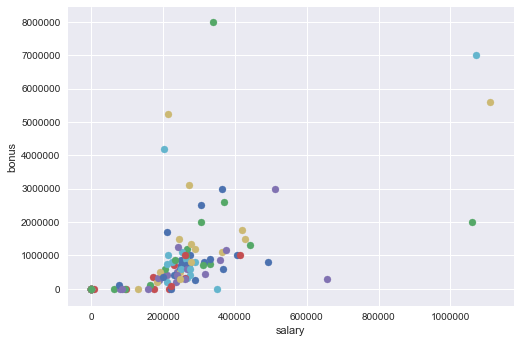

In [14]:
### look at salary and bonus, plotted again
for point in data:
    salary = point[1]
    bonus = point[5]
    mpl.pyplot.scatter( salary, bonus )

mpl.pyplot.xlabel("salary")
mpl.pyplot.ylabel("bonus")
mpl.pyplot.show()


### Initial Statistics

#### Stats 1
#### Stats 2

#### Inputations

### Questions in Detail

#### Question 1
#### Question 2

### Conclusions

### Assumptions

##### Sources, Credits, Footnote

##### Version History
1.0, 06/30/2017, Created